In [49]:
import os
import pandas as pd

directory_path = './data/raw-txt'

alignment_df = pd.read_csv('./data/combined_csv.csv')
def ensure_txt_extension(filename):
    if pd.isnull(filename):
        return None 
    if not filename.endswith('.txt'):
        return f"{filename}.txt"
    return filename
alignment_df['filename'] = alignment_df['filename'].apply(ensure_txt_extension)


def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

documents_list = []
ranks = []
uni_names = []

for index, row in alignment_df.iterrows():
   
    if not pd.isna(row['filename']) and isinstance(row['filename'], str):
        file_path = os.path.join(directory_path, row['filename'])
        if os.path.exists(file_path):
            text = read_txt(file_path)
            documents_list.append(text)
            ranks.append(row['qs_ranking'])
            uni_names.append(row['institution'])
        else:
            print(f"File does not exist: {file_path}")
    else:
        
        print(f"Invalid or missing filename at index {index}")

# Convert lists to DataFrame
documents_df = pd.DataFrame({
    'document': documents_list,
    'rank': ranks,
    'institution': uni_names
})



File does not exist: ./data/raw-txt\nus.txt
File does not exist: ./data/raw-txt\205 Universitat Hamburg.txt
File does not exist: ./data/raw-txt\Università Sacro Cuore.txt
File does not exist: ./data/raw-txt\Université de Fribourg.txt
File does not exist: ./data/raw-txt\Universidad Adolfo Ibáñez.txt
File does not exist: ./data/raw-txt\HUFS.txt
File does not exist: ./data/raw-txt\Andres Bello Catholic University.txt
File does not exist: ./data/raw-txt\University Vita-Salute San Raffaele.txt
File does not exist: ./data/raw-txt\Saarland University des Saarlandes.txt


In [2]:
documents_df

,document,rank,institution
0,"\n \nMIT Strategic Action Plan for Belonging, ...",1,Massachusetts Institute of Technology (MIT)
1,The University's mission and core values \nMi...,2,University of Cambridge
2,University of Oxford \nStrategic Plan \n2018–...,3,University of Oxford
3,Strategy and \nDevelopment Plan \n2021–2024\n\...,7,ETH Zurich - Swiss Federal Institute of Techno...
4,PENN’S FOCUS ON TOMORROW \nA Strategic Framewo...,12,University of Pennsylvania
...,...,...,...
239,Every one of the University of Klagenfurt’s ac...,580,University of Klagenfurt
240,ASU STRATEGIC PLAN (2020-2025)\nwww.asu.edu.b...,582,Applied Science University - Bahrain
241,STRATEGIC \nPLAN\nTerm 2016-18\nDecember 2016...,582,Universidad Pontificia Comillas
242,University for Missouri \nTheFLAGSHIP of theFU...,586,"University of Missouri, Columbia"


In [3]:
documents_df.to_csv("csv_output_path", index=False)

In [4]:
import gensim
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from langdetect import detect

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Function to detect phrases in the documents
def detect_phrases(docs):
    phrases = Phrases(docs, min_count=5, threshold=12) 
    phraser = Phraser(phrases)
    return phraser


def preprocess_with_phrases(text, phraser):
    text = text.lower()
    text = "".join(re.findall("[a-z\s]*", text))
    words = text.split()

    filtered_text = [word for word in words if word not in stop_words]
    filtered_text = [word for word in words if len(word) > 2 and '_' not in word and word not in stop_words]
    filtered_text = phraser[filtered_text] 
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    return lemmatized_text

# tokenize the documents for phrase detection
tokenized_docs = [[word for word in document.lower().split() if word not in stop_words] for document in documents_df['document']]

# Detect phrases
phraser = detect_phrases(tokenized_docs)


processed_docs_with_phrases = [preprocess_with_phrases(text, phraser) for text in documents_df['document']]

#Creating dictionary and bow_corpus using the processed_docs_with_phrases
dictionary = gensim.corpora.Dictionary(processed_docs_with_phrases)
dictionary.filter_extremes(no_below=8, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs_with_phrases]


In [5]:
external_metrics = documents_df['rank'].to_numpy()

In [6]:
from gensim.models import LdaMulticore
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import pearsonr
import os

def evaluate_model_coherence(lda_model, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
    return coherence_model.get_coherence()

def train_and_evaluate_models(corpus, id2word, texts, num_topics_list, passes=10, random_state=42, top_n_models=3, checkpoint_dir="model/"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    model_list = []
    coherence_scores = []
    model_paths = []

    for num_topics in num_topics_list:
        model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, 
                             passes=passes, random_state=random_state, workers=4)
        model_path = os.path.join(checkpoint_dir, f"lda_model_{num_topics}.model")
        model.save(model_path)
        model_paths.append(model_path)
        
        coherence_score = evaluate_model_coherence(model, texts, id2word)
        model_list.append(model)
        coherence_scores.append(coherence_score)
        print(f"Model with {num_topics} topics saved at {model_path} with coherence score {coherence_score}")

    top_indices = np.argsort(coherence_scores)[-top_n_models:]
    top_models = [model_list[i] for i in top_indices]
    top_scores = [coherence_scores[i] for i in top_indices]
    top_model_paths = [model_paths[i] for i in top_indices]

    return top_models, top_scores, top_model_paths

import numpy as np


def process_models_and_extract_features(top_models, corpus, id2word, chosen_number_of_topics):
    feature_vectors = np.zeros((len(corpus), chosen_number_of_topics))
    averaged_topics = [[] for _ in range(chosen_number_of_topics)]
    topic_distributions = []  # List to store topic distributions for all documents

    # Iterate over each document in the corpus
    for i, doc_bow in enumerate(corpus):
        doc_topics_avg = np.zeros(chosen_number_of_topics)
        doc_topic_distribution = []  # List to store topic distribution for this document
        
        # Iterate over each model to get the topic distribution for the document
        for model in top_models:
            doc_topics = dict(model.get_document_topics(doc_bow, minimum_probability=0))
            model_doc_topic_distribution = {}
            for topic_num, prob in doc_topics.items():
                if topic_num < chosen_number_of_topics:  # Ensure topic_num is within the specified number of topics
                    doc_topics_avg[topic_num] += prob / len(top_models)
                    model_doc_topic_distribution[topic_num] = prob  # Store topic distribution for this model
            doc_topic_distribution.append(model_doc_topic_distribution)
        
        # Update the feature vector for the document
        feature_vectors[i, :] = doc_topics_avg
        topic_distributions.append(doc_topic_distribution)  # Store topic distribution for this document
    
    # Collect and average topic terms across models
    for topic_num in range(chosen_number_of_topics):
        topic_terms = {}
        for model in top_models:
            if topic_num < model.num_topics:  # Ensure topic_num is within the model's number of topics
                for term_id, weight in model.get_topic_terms(topic_num, topn=20):
                    topic_terms[term_id] = topic_terms.get(term_id, 0) + weight / len(top_models)
        averaged_terms = sorted(topic_terms.items(), key=lambda x: -x[1])[:20]
        averaged_topics[topic_num] = averaged_terms
    
    # Print averaged topics
    print("\nAveraged Topics:")
    for idx, terms in enumerate(averaged_topics):
        if terms:  # Only print if there are terms for this topic
            terms_str = " + ".join([f"{weight:.3f}*{id2word[term]}" for term, weight in terms])
            print(f"Topic {idx}: {terms_str}")

    return feature_vectors, topic_distributions



def calculate_correlation(feature_vectors, external_metrics):
    correlations = []
    for i in range(feature_vectors.shape[1]):
        correlation, _ = pearsonr(feature_vectors[:, i], external_metrics)
        correlations.append(correlation)
    
    return correlations


num_topics_list = [4, 10, 15, 20]
top_n_models = 2

top_models, top_scores, top_model_paths = train_and_evaluate_models(bow_corpus, dictionary, texts=processed_docs_with_phrases, num_topics_list=num_topics_list, top_n_models=top_n_models)


Model with 4 topics saved at model/lda_model_4.model with coherence score 0.32360220560546205
Model with 10 topics saved at model/lda_model_10.model with coherence score 0.34999992003178704
Model with 15 topics saved at model/lda_model_15.model with coherence score 0.3733435528180761
Model with 20 topics saved at model/lda_model_20.model with coherence score 0.3969464301863036


In [7]:
from sklearn.preprocessing import normalize

chosen_number_of_topics=10
feature_vectors , topdis= process_models_and_extract_features(top_models, corpus=bow_corpus, id2word=dictionary, chosen_number_of_topics=chosen_number_of_topics)
normalized_feature_vectors = normalize(feature_vectors, norm='l2')


Averaged Topics:
Topic 0: 0.024*york + 0.015*universit + 0.012*paris + 0.008*indigenous + 0.005*equality + 0.004*programme + 0.004*scholarship + 0.004*supporting + 0.004*environmental + 0.004*outcome + 0.003*centre + 0.003*shall + 0.003*critical + 0.003*equity + 0.003*governance + 0.002*canada + 0.002*achieved + 0.002*health_care + 0.001*scientific + 0.001*table
Topic 1: 0.017*kpi + 0.009*estate + 0.005*innovation_entrepreneurship + 0.004*state + 0.003*sponsored + 0.003*asia + 0.003*sport + 0.003*cost + 0.003*centre + 0.003*scholarship + 0.003*park + 0.003*read + 0.002*refurbishment + 0.002*internationalisation + 0.002*growing + 0.002*pillar + 0.002*energy + 0.002*experiential_learning + 0.002*company + 0.002*unit
Topic 2: 0.007*programme + 0.005*scientific + 0.004*sdgs + 0.004*centre + 0.003*therefore + 0.003*organisation + 0.003*cooperation + 0.003*context + 0.003*section + 0.003*may + 0.003*dimension + 0.002*creation + 0.002*promoting + 0.002*professor + 0.002*different + 0.002*too

In [77]:
print(normalized_feature_vectors)

[[3.73384512e-05 3.73384548e-05 3.73384621e-05 ... 3.73385622e-05
  3.73384639e-05 3.73384585e-05]
 [2.13281062e-03 2.13280974e-03 2.13281062e-03 ... 2.13280961e-03
  8.18361562e-01 2.13281024e-03]
 [4.37049791e-01 3.21176695e-02 2.44983736e-04 ... 3.43692426e-02
  5.08189911e-02 2.44983672e-04]
 ...
 [8.60574759e-04 8.60574966e-04 8.33117377e-01 ... 8.60574759e-04
  8.60574656e-04 5.53090870e-01]
 [2.76639437e-05 2.76639479e-05 2.76639550e-05 ... 2.19785574e-01
  8.58755511e-01 2.76639493e-05]
 [5.42632953e-05 5.42632991e-05 5.64772157e-02 ... 9.53515755e-02
  9.41364034e-01 1.16661403e-01]]


In [52]:
print(len(topdis))

244


In [79]:
#Generating similarity matrix using the cosin similarity
from scipy.spatial.distance import cosine, pdist, squareform
# top 10 topics decided
num_topics = 10 

# Convert each distribution into a list of probabilities
doc_vectors = []
for feature_vector in normalized_feature_vectors:  # Loop over the feature vectors
    doc_vector = feature_vector[:num_topics]  # Take the first `num_topics` elements
    doc_vectors.append(doc_vector)


matrix = np.array(doc_vectors)

# Calculate pairwise cosine similarities using scipy's spatial distance functions
similarity_matrix = 1 - squareform(pdist(matrix, 'cosine'))

print(similarity_matrix.shape)


print(similarity_matrix)


(244, 244)
[[1.00000000e+00 2.19415569e-03 8.42974583e-03 ... 9.12558771e-04
  4.62816040e-01 1.84773512e-01]
 [2.19415569e-03 1.00000000e+00 4.24058492e-01 ... 4.36857101e-03
  7.07851006e-01 7.74293210e-01]
 [8.42974583e-03 4.24058492e-01 1.00000000e+00 ... 1.59599420e-03
  6.27010918e-02 5.68003971e-02]
 ...
 [9.12558771e-04 4.36857101e-03 1.59599420e-03 ... 1.00000000e+00
  1.37217138e-03 1.12832425e-01]
 [4.62816040e-01 7.07851006e-01 6.27010918e-02 ... 1.37217138e-03
  1.00000000e+00 9.14891333e-01]
 [1.84773512e-01 7.74293210e-01 5.68003971e-02 ... 1.12832425e-01
  9.14891333e-01 1.00000000e+00]]


In [80]:
num_rows, num_columns = similarity_matrix.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 244
Number of columns: 244


In [129]:
#Check to see if the number of nodes are equivalent to number of universities
graph_nodes = set(G.nodes())


df_institutions = set(documents_df['institution'])

# Check for any mismatches
mismatched_labels = df_institutions - graph_nodes
if mismatched_labels:
    print("Mismatched labels found:", mismatched_labels)
else:
    print("All labels match.")


All labels match.


In [70]:
# Show total number of nodes
print("Total number of nodes in the graph:", G)

Total number of nodes in the graph: Graph with 244 nodes and 3702 edges


C:\Users\Rupali\AppData\Local\Temp\ipykernel_9660\3368717885.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


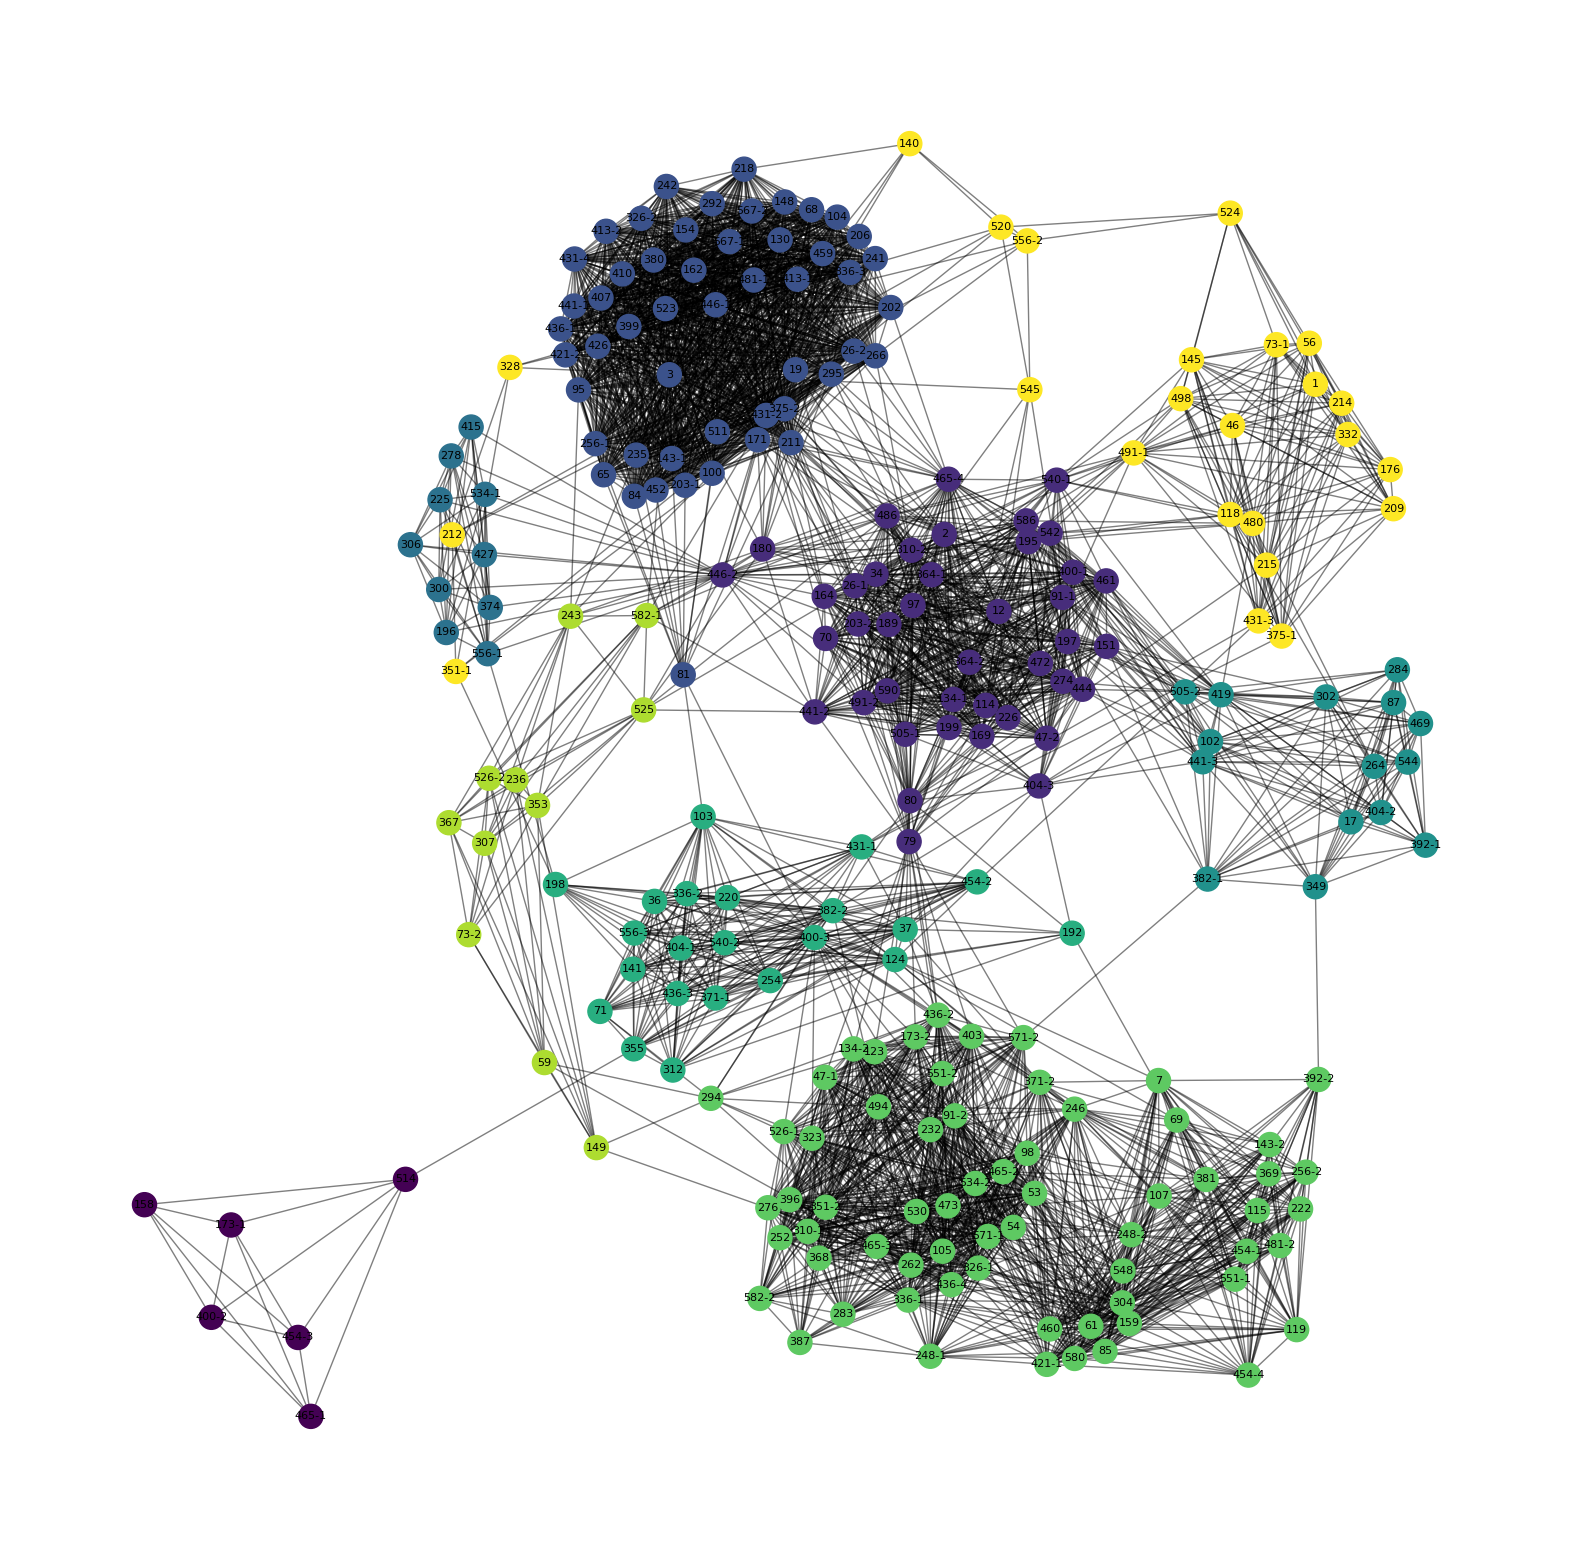

In [92]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain
import matplotlib.cm as cm
import pandas as pd

# Assume 'G' is your pre-existing graph, 'documents_df' is your DataFrame, and 'pos' is the positions of your nodes.
# Compute the best partition
partition = community_louvain.best_partition(G, weight='weight')


rank_dict = {}
unique_label_dict = {}

for _, row in documents_df.iterrows():
    institution = row['institution']
    rank = row['rank']
    if rank not in rank_dict:
        rank_dict[rank] = [institution] 
    else:
        rank_dict[rank].append(institution) 

#Univque lable for institution with same rank
for rank, institutions in rank_dict.items():
    if len(institutions) == 1:
        unique_label_dict[institutions[0]] = str(rank)
    else:
        for count, institution in enumerate(institutions, start=1):
            unique_label_dict[institution] = f"{rank}-{count}"

# Create a label mapping for nodes in the graph
node_labels = {node: unique_label_dict[data['label']] for node, data in G.nodes(data=True) if data['label'] in unique_label_dict}


plt.figure(figsize=(20, 20))
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

nx.draw_networkx_nodes(G, pos, node_size=300, cmap=cmap, node_color=list(partition.values()))

nx.draw_networkx_edges(G, pos, alpha=0.5)

nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)

plt.axis('off') 
plt.show()
